# Pysindy with DEC data

In [1]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh import util
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat
from matplotlib import cm
import pysindy as ps
from alpine.data.util import load_dataset
from alpine.data.burgers.burgers_dataset import data_path

In [2]:
config()

In [3]:
# SPACE PARAMS
L = 5.05
L_norm = 1
# spatial resolution
dx = 0.05
#  Number of spatial grid points
num_x_points = int(-(-L // dx))
num_x_points_norm = num_x_points

# vector containing spatial points
x = np.linspace(0, L, num_x_points)
x_circ = (x[:-1] + x[1:])/2

# initial velocity
u_0 = 2 * np.exp(-2 * (x_circ - 0.5 * L)**2)
umax = np.max(u_0)

# TIME PARAMS
T = 2
T_norm = T*umax/L
# temporal resolution
dt = 0.01
dt_norm = dt*umax/L
# number of temporal grid points
num_t_points_norm = int(-(-T_norm // dt_norm))

t = np.linspace(0, T_norm, num_t_points_norm)

In [4]:
# generate mesh
mesh, _ = util.generate_line_mesh(num_x_points_norm, L_norm)
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_PDP_weights()
# get circ
circ = S.circ[1][:,0]

In [5]:
# load data
time_train, time_val, time_test, u_train_T, u_val_T, u_test_T = load_dataset(
    data_path, "npy")

In [6]:
# reconstruct full data (only for plot)
full_u_data_T = np.zeros((num_t_points_norm, num_x_points_norm-1))
full_u_data_T[time_train] = u_train_T
full_u_data_T[time_val] = u_val_T
full_u_data_T[time_test] = u_test_T

In [7]:
u = full_u_data_T.T
u_dot_true = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

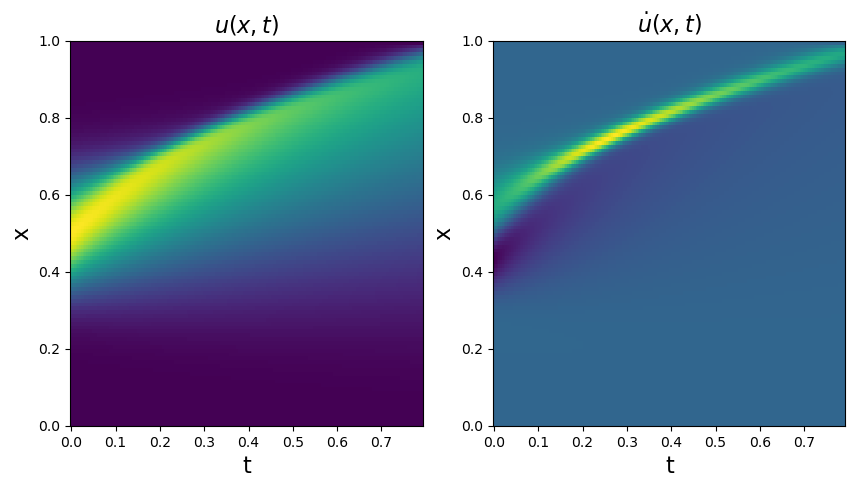

In [8]:
# PLOT FULL DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, circ, u)
ax[1].pcolormesh(t,circ,u_dot_true)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

## Training

In [9]:
# define u_training
training_time = np.concatenate((time_train, time_val))

# sort times in the correct order
train_sort_map = np.argsort(training_time)
training_time_ord = training_time[train_sort_map]
t_training = t[training_time_ord]

u_training_unordered = np.vstack((u_train_T, u_val_T)).T
# sort u_training w.r.t. times
u_training = u_training_unordered[:, train_sort_map]

# define u_training_dot
u_dot_training_true = u_dot_true[:, training_time_ord]

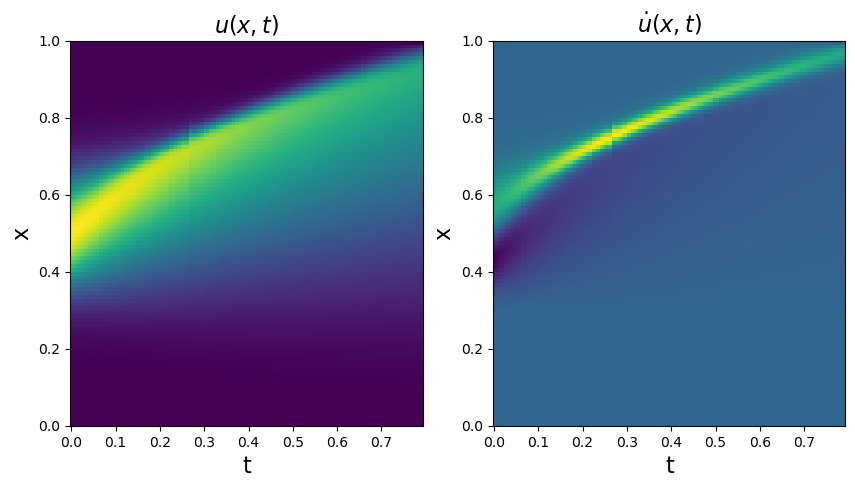

In [10]:
# PRINT TRAINING DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_training, circ, u_training)
ax[1].pcolormesh(t_training,circ,u_dot_training_true)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [11]:
# reshape u_training and u_dot_training
u_training_reshape = u_training.reshape(len(circ), len(training_time), 1)
u_training_dot_reshape = u_dot_training_true.reshape(u_dot_training_true.shape[0], 
                                                     u_dot_training_true.shape[1], 1)

In [12]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=5,
    spatial_grid=circ,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-4, normalize_columns=True, verbose=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
#model.fit(u, t=dt, x_dot= u_dot)
model.fit(u_training_reshape, x_dot =u_training_dot_reshape)
model.print()

STLSQ model: 
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 2.5311e+01 ... 5.6465e-01 ...          7 ... 2.5876e+01
         1 ... 1.2291e+01 ... 6.2024e-01 ...          3 ... 1.2912e+01
         2 ... 3.2935e+00 ... 6.4999e-01 ...          2 ... 3.9435e+00
         3 ... 3.2838e+00 ... 6.4807e-01 ...          2 ... 3.9319e+00
(x0)' = 0.002 x0_11 + -0.396 x0x0_1


In [13]:
# compute training error
u_dot_training = model.predict(u_training_reshape)[:,:,0]
print(np.mean(np.linalg.norm(u_dot_training_true - u_dot_training, axis=0)**2))

0.020523509094895885


## Test

In [14]:
test_sort_map = np.argsort(time_test)
test_time_ordered = time_test[test_sort_map]

u_test = u_test_T.T[:, test_sort_map]
u_test_reshape = u_test.reshape(u_test.shape[0], u_test.shape[1], 1)

In [15]:
# define u_dot_test_true
u_dot_test_true = u_dot_true[:, test_time_ordered]
# compute test prediction for u_dot
u_dot_test = model.predict(u_test_reshape)[:,:,0]

In [16]:
# compute test error
print(np.mean(np.linalg.norm(u_dot_test_true - u_dot_test, axis=0)**2))

0.014618937835251023


## True $\dot{u}$ vs computed $\dot{u}$

In [17]:
# reconstruct u_dot
u_dot = np.zeros_like(u_dot_true)

u_dot[:, training_time_ord] = u_dot_training
u_dot[:, test_time_ordered] = u_dot_test

In [18]:
# compute total error
print(np.mean(np.linalg.norm(u_dot_true - u_dot, axis=0)**2))

0.019342594842966913


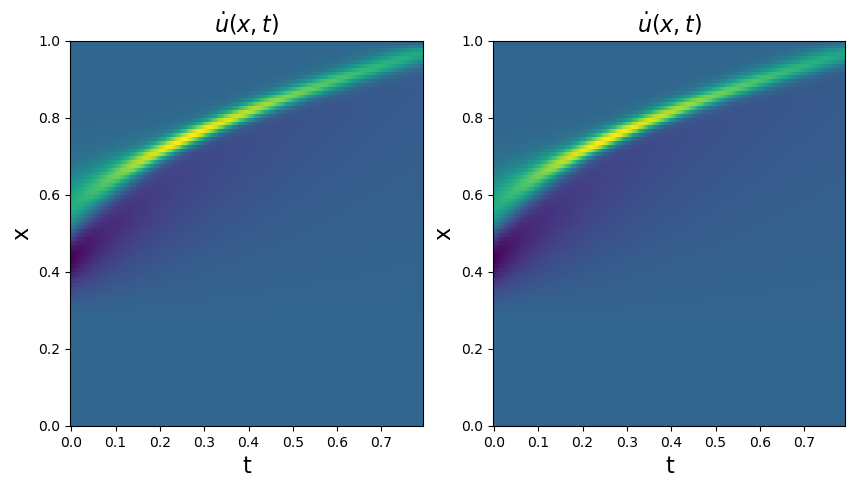

In [19]:
# COMPARISON udot_true VS udot_predict 
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, circ, u_dot_true)
ax[1].pcolormesh(t,circ,u_dot)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$\dot{u}(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()